In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import model.Spectra_MAE as spectra_mae


def show_spectra(x, y, title=''):
    plt.figure(figsize=(10, 6), dpi=150)        # figsize=(12, 4)
    plt.plot(x, y, c='#82B0D2')
    plt.ylim((0, 1))
    # plt.savefig('./restruction_pathogenic_figure.jpeg')
    plt.show()

def show_masked(x, y, title=''):
    plt.figure(figsize=(10, 6), dpi=150)
    ax = plt.gca()
    ax.spines['bottom'].set_position(("data", 0))       # 调整x轴
    ax.spines['top'].set_visible(False)             # 去掉上侧边框
    ax.spines['right'].set_visible(False)           # 去掉右侧边框
    plt.ylim((-0.2, 1))
    for i in range(0, 1000, 100):               # 1000
        plt.plot(x[i:i+100], y[i:i+100], color='#1f77b4',)
    # plt.savefig('./masked_pathogenic_figure.jpeg')

def prepare_model(chkpt_dir, arch='spectraMAE_base_patch50'):
    model = getattr(spectra_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cuda:0')
    msg = model.load_state_dict(checkpoint)
    print(msg)
    return model

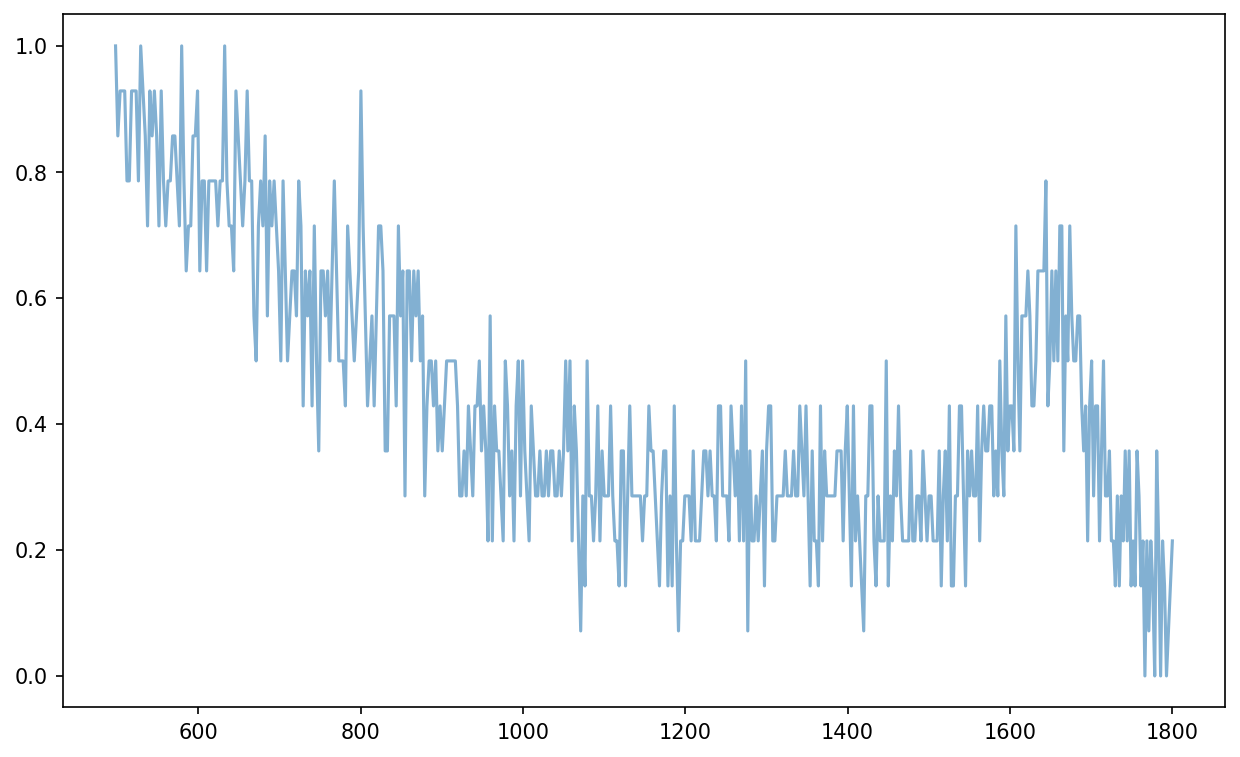

In [27]:
# Pathogenic
import scipy
from utils.DenoisingData import RamanDataset

with open('dataset/axis.txt') as file:
    lines = [line.rstrip() for line in file]
wavenumbers = [float(wave) for wave in lines if wave != '']

Input_TestData = scipy.io.loadmat('dataset/Test_Inputs.mat')['Test_Inputs']
Output_GT_TestData = scipy.io.loadmat('dataset/Test_Outputs.mat')['Test_Outputs']

Input_TestData_norm = RamanDataset(inputs=Input_TestData, outputs=Output_GT_TestData, )
input_exam = Input_TestData_norm[1].detach().numpy()
input_exam = input_exam.squeeze(0)

Output_TestData_norm = RamanDataset(inputs=Output_GT_TestData, outputs=Output_GT_TestData, )
output_exam = Output_TestData_norm[1].detach().numpy()
output_exam = output_exam.squeeze(0)

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(wavenumbers, input_exam, c='#82B0D2')             # #82B0D2
plt.show()

In [8]:
chkpt_dir = 'denoising_param/10_final.pth'
model_mae = prepare_model(chkpt_dir=chkpt_dir)
print('Model loaded.')

<All keys matched successfully>
Model loaded.


/tmp/ipykernel_4134688/799943151.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cuda:0')


In [24]:
spectra_tensor = torch.from_numpy(input_exam).view(1, -1).float()
spectra_tensor = spectra_tensor.view(1, 1, 500)
loss, pred, mask = model_mae(spectra_tensor, mask_ratio=0.5)
pred = model_mae.unpatchify(pred)
pred = pred.detach().numpy()
pred = pred.reshape(500, )

mask = mask.detach()
mask = mask.unsqueeze(-1).repeat(1, 1, 50)
mask = model_mae.unpatchify(mask)
mask = mask.cpu().detach().numpy().reshape(500, )

im_mask = input_exam.copy()
for i in range(0, 500, 50):
    if mask[i] == 1:
        im_mask[i: i+50] = [(j * (1 - mask[i // 50]) - 0.1 )for j in input_exam[i:i+50]]

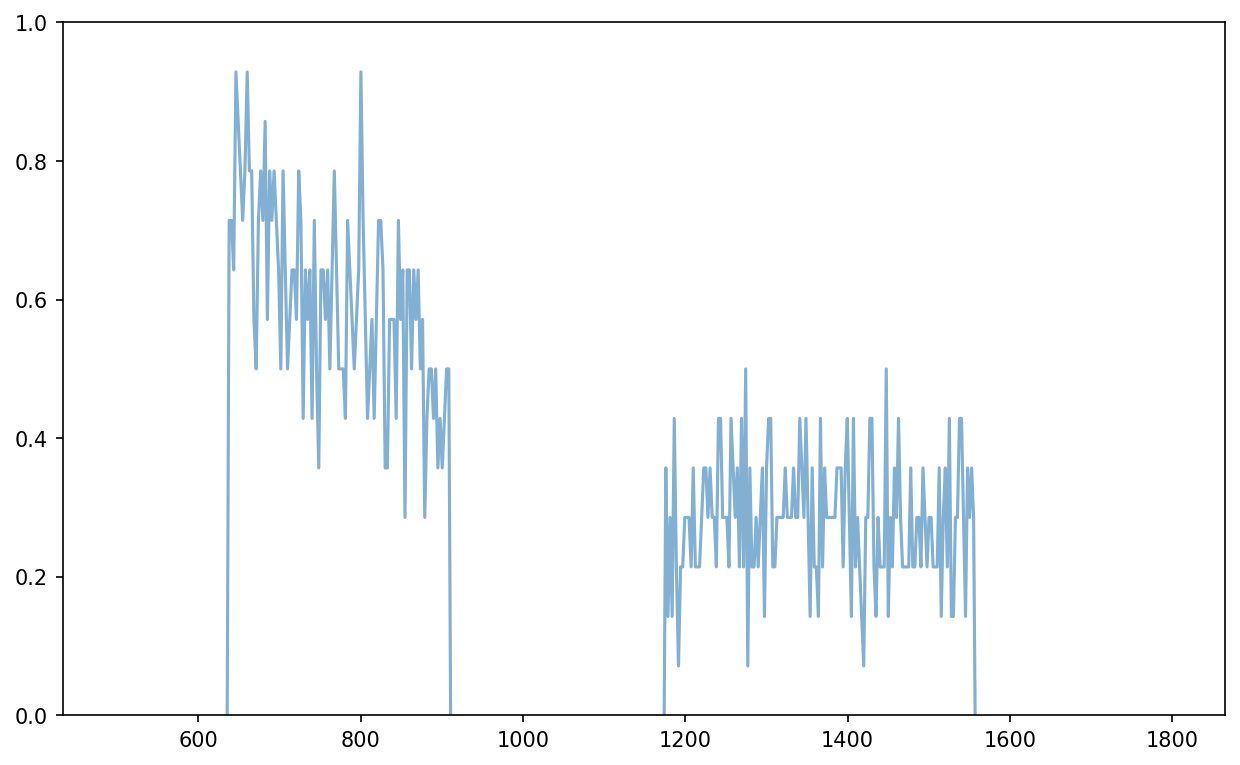

In [25]:
show_spectra(wavenumbers, im_mask, 'reconstruction')

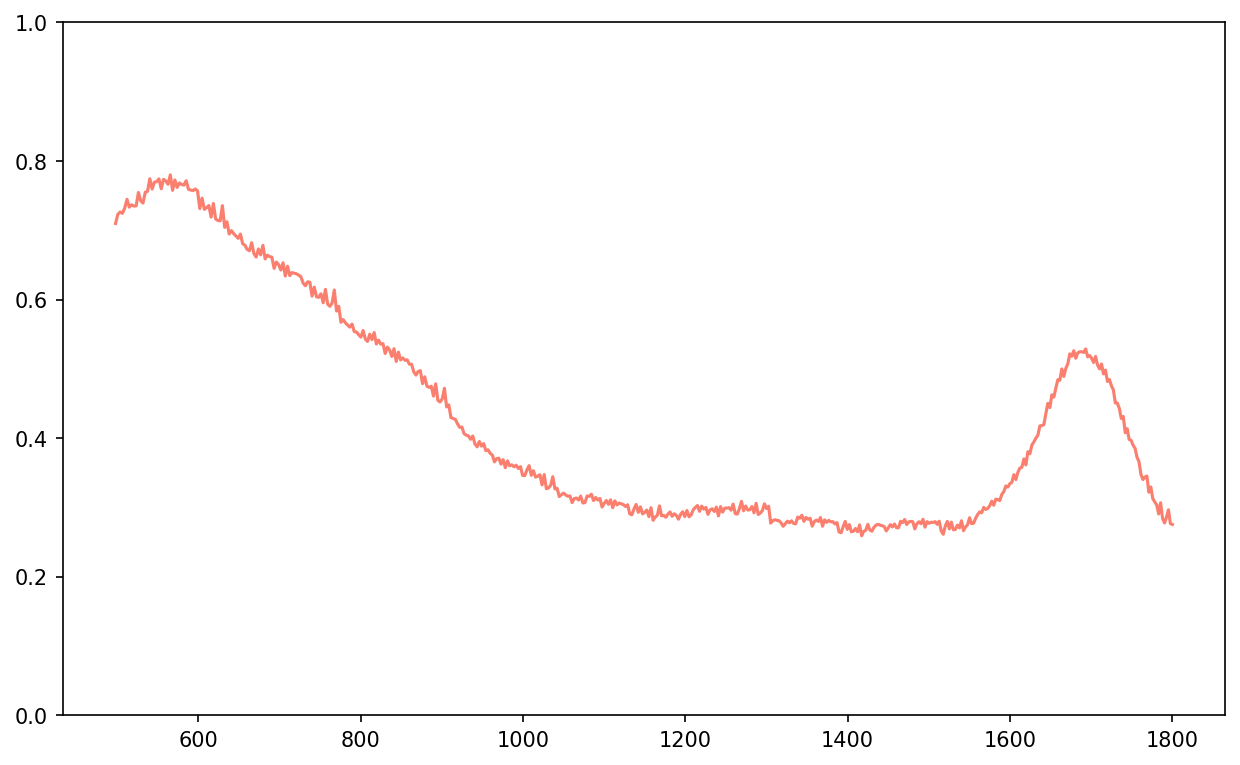

In [26]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(wavenumbers, pred, c='#FA7F6F')

plt.ylim((0, 1))
# plt.savefig('./restruction_pathogenic_figure.jpeg')
plt.show()

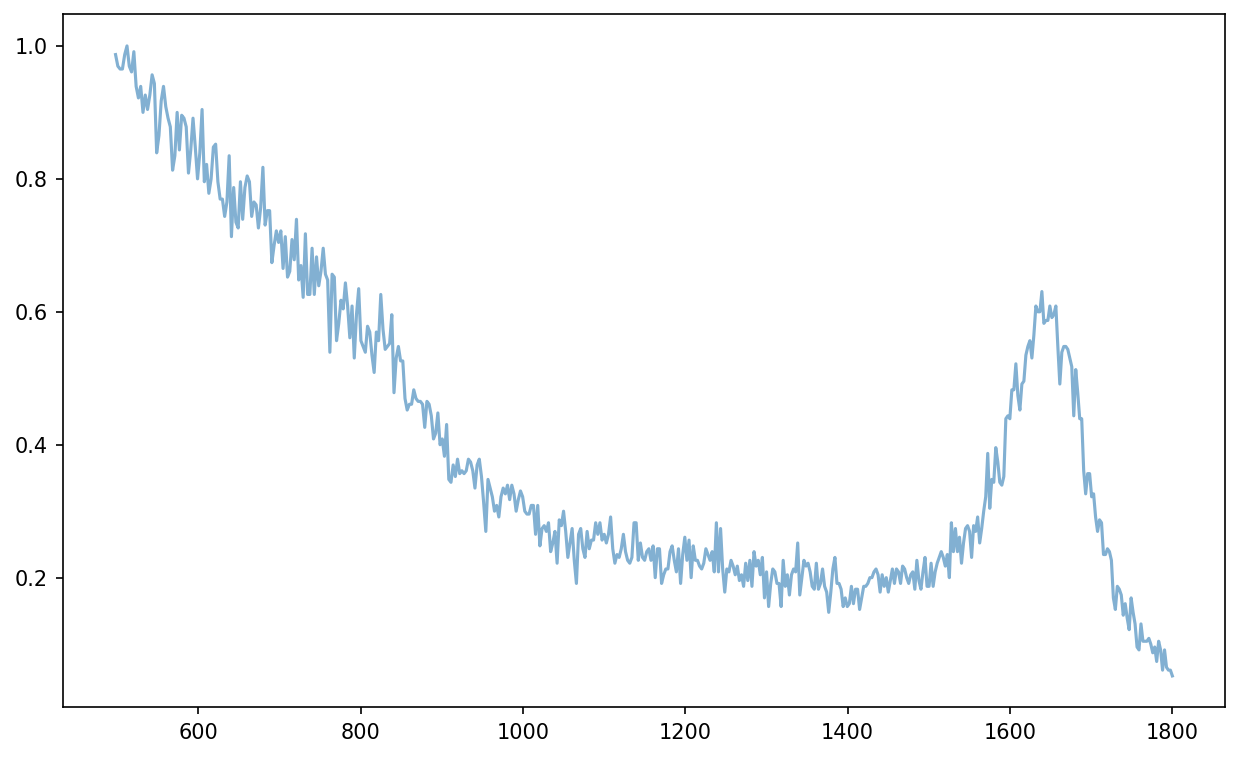

In [28]:

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(wavenumbers, output_exam, c='#82B0D2')             # #82B0D2
plt.show()